# Lab 7

- Daniel Rayo 22933
- Nombre carne
- Nombre carne
- Nombre carne

In [15]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [16]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

## Red Neuronal

Se utilizo una rede neuronal totalmente conectada de 3 capas de 128 neuronas cada una. El objetivo de la red es poder predecir los *"Quality values"* (tambien llamados *Q-values*) asociados a cada acción que se puede tomar dado un contexto/estado actual.

In [17]:
class DQN(nn.Module):
    """Deep Q-Network architecture."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

## Replay Buffer

El replay buffer es una cola (una lista con una capacidad máxima, cuando se consigue la cantidad máxima, el primer elemento es desechado para agregar otro) que guarda un historial de las acciones pasadas tomadas en las diferentes situaciones vividas junto con la recompensa obtenida. 

Realmente la red neuronal no trabajara con los valores inmediatos dados por gymnasium, sino que usara el Replay Buffer como su dataset de entrada para poder entrenarse, esto permite a la red todavía iterar sobre ejemplos pasados, y evitar cometer los mismos errores. 

In [2]:
class ReplayBuffer:
    """Experience replay buffer for storing and sampling experiences."""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer."""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Sample random batch of experiences."""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

## Agente

In [ ]:
class DQNAgent:
    """DQN Agent with online and target networks."""
    
    def __init__(
        self,
        env,
        learning_rate=0.001,
        initial_epsilon=1.0,
        epsilon_decay=0.995,
        final_epsilon=0.01,
        discount_factor=0.99,
        buffer_capacity=10000,
        batch_size=64,
        target_update_frequency=100,
        hidden_size=128
    ):
        """Initialize DQN agent.
        
        Args:
            env: Gymnasium environment
            learning_rate: Learning rate for optimizer
            initial_epsilon: Starting exploration rate
            epsilon_decay: Decay factor for epsilon per episode
            final_epsilon: Minimum exploration rate
            discount_factor: Discount factor for future rewards
            buffer_capacity: Size of experience replay buffer
            batch_size: Number of experiences to sample for training
            target_update_frequency: How often to update target network every 'n' episodes
            hidden_size: Size of hidden layers in neural networks
        """
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Get environment dimensions
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        # Create online and target networks
        self.online_network = DQN(self.state_size, hidden_size, self.action_size).to(self.device)
        self.target_network = DQN(self.state_size, hidden_size, self.action_size).to(self.device)
        
        # Initialize target network with same weights as online network
        self.target_network.load_state_dict(self.online_network.state_dict())
        self.target_network.eval()  # Target network is not trained directly
        
        # Optimizer and loss function for the online network
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
        # Hyperparameters
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.target_update_frequency = target_update_frequency
        
        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # Experience replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        
        # Training tracking
        self.episode_count = 0
        self.losses = []
        self.episode_rewards = []
    
    def get_action(self, state):
        """Choose action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            # Explore: random action
            return self.env.action_space.sample()
        else:
            # Exploit: best action according to online network
            with torch.no_grad():
                # Let the network predict the Q-values for the current state
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.online_network(state_tensor)
                # Choose the action with higher Q-value
                return q_values.argmax().item()
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def train_step(self):
        """Perform one training step using experience replay."""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample batch from replay buffer
        batch = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor([exp.state for exp in batch]).to(self.device)
        actions = torch.LongTensor([exp.action for exp in batch]).to(self.device)
        rewards = torch.FloatTensor([exp.reward for exp in batch]).to(self.device)
        next_states = torch.FloatTensor([exp.next_state for exp in batch]).to(self.device)
        dones = torch.BoolTensor([exp.done for exp in batch]).to(self.device)
        
        # Let online network choose the action with hightest Q-value 
        # for each state of the batch.
        current_q_values = self.online_network(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            # Let target_network predict the q-values for each action in the next states.
            next_q_values = self.target_network(next_states).max(1)[0]
            # Use the predictions from the line above, to calculate the actual expected q-values
            # that the online-network should've predicted.
            # using Bellman equation
            target_q_values = rewards + (self.discount_factor * next_q_values * ~dones)
        
        # Compute loss and update online network
        loss = self.criterion(current_q_values.squeeze(), target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
    
    def update_target_network(self):
        """Copy weights from online network to target network."""
        self.target_network.load_state_dict(self.online_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)
    
    def train(self, n_episodes):
        """Train the agent for specified number of episodes."""
        print(f"Training DQN agent for {n_episodes} episodes...")
        
        for episode in tqdm(range(n_episodes), desc="Training"):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                # Choose and take action
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                # Store experience
                self.store_experience(state, action, reward, next_state, done)
                
                # Train the network
                self.train_step()
                
                episode_reward += reward
                state = next_state
            
            # Update target network periodically
            if episode % self.target_update_frequency == 0:
                self.update_target_network()
            
            # Decay exploration rate
            self.decay_epsilon()
            
            # Track progress (for plotting learning rate latter)
            self.episode_rewards.append(episode_reward)
            self.episode_count += 1
            
            # Print progress every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")

### Función de testeo

In [ ]:
def test_agent(agent, env, num_episodes=100, render=False):
    """Test the trained agent."""
    print(f"\nTesting agent for {num_episodes} episodes...")
    
    # Disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    test_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        
        test_rewards.append(episode_reward)
    
    # Restore epsilon
    agent.epsilon = old_epsilon
    
    # Print results
    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)
    max_reward = np.max(test_rewards)
    
    print(f"Test Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Max Reward: {max_reward}")
    print(f"Success Rate (>195): {np.mean(np.array(test_rewards) > 195):.1%}")
    
    return test_rewards

In [21]:
def plot_training_progress(agent):
    """Plot training progress."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot episode rewards
    ax1.plot(agent.episode_rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(True)
    
    # Plot moving average of rewards
    if len(agent.episode_rewards) >= 100:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(100)/100, mode='valid')
        ax1.plot(range(99, len(agent.episode_rewards)), moving_avg, color='red', label='100-episode average')
        ax1.legend()
    
    # Plot training losses
    if agent.losses:
        ax2.plot(agent.losses)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

### Entrenamiento del agente

Using device: cuda
Training DQN agent for 2000 episodes...


Training:   0%|          | 6/2000 [00:00<00:37, 53.13it/s]

Episode 0, Average Reward: 14.00, Epsilon: 0.995


Training:   5%|▌         | 104/2000 [00:04<01:17, 24.43it/s]

Episode 100, Average Reward: 16.32, Epsilon: 0.603


Training:  10%|█         | 204/2000 [00:09<01:08, 26.06it/s]

Episode 200, Average Reward: 17.18, Epsilon: 0.365


Training:  15%|█▌        | 303/2000 [00:13<01:18, 21.50it/s]

Episode 300, Average Reward: 16.77, Epsilon: 0.221


Training:  20%|█▉        | 399/2000 [00:25<03:16,  8.14it/s]

Episode 400, Average Reward: 39.23, Epsilon: 0.134


Training:  25%|██▌       | 502/2000 [00:50<05:01,  4.97it/s]

Episode 500, Average Reward: 87.08, Epsilon: 0.081


Training:  30%|███       | 601/2000 [01:31<07:50,  2.98it/s]

Episode 600, Average Reward: 134.05, Epsilon: 0.049


Training:  35%|███▌      | 701/2000 [02:30<13:37,  1.59it/s]

Episode 700, Average Reward: 190.74, Epsilon: 0.030


Training:  40%|████      | 801/2000 [03:30<12:10,  1.64it/s]

Episode 800, Average Reward: 184.74, Epsilon: 0.018


Training:  45%|████▌     | 904/2000 [03:50<01:53,  9.65it/s]

Episode 900, Average Reward: 60.88, Epsilon: 0.011


Training:  50%|█████     | 1001/2000 [04:17<06:30,  2.56it/s]

Episode 1000, Average Reward: 88.94, Epsilon: 0.010


Training:  55%|█████▌    | 1102/2000 [04:40<01:37,  9.19it/s]

Episode 1100, Average Reward: 66.73, Epsilon: 0.010


Training:  60%|██████    | 1201/2000 [05:17<06:08,  2.17it/s]

Episode 1200, Average Reward: 114.63, Epsilon: 0.010


Training:  65%|██████▌   | 1301/2000 [06:35<08:00,  1.46it/s]

Episode 1300, Average Reward: 239.02, Epsilon: 0.010


Training:  70%|███████   | 1401/2000 [07:37<05:53,  1.70it/s]

Episode 1400, Average Reward: 185.51, Epsilon: 0.010


Training:  75%|███████▌  | 1501/2000 [08:10<01:44,  4.77it/s]

Episode 1500, Average Reward: 103.19, Epsilon: 0.010


Training:  80%|████████  | 1601/2000 [09:39<06:44,  1.01s/it]

Episode 1600, Average Reward: 277.72, Epsilon: 0.010


Training:  85%|████████▌ | 1701/2000 [11:43<02:00,  2.49it/s]

Episode 1700, Average Reward: 375.35, Epsilon: 0.010


Training:  90%|█████████ | 1801/2000 [12:45<01:35,  2.08it/s]

Episode 1800, Average Reward: 190.38, Epsilon: 0.010


Training:  95%|█████████▌| 1901/2000 [13:54<00:53,  1.85it/s]

Episode 1900, Average Reward: 211.87, Epsilon: 0.010


Training: 100%|██████████| 2000/2000 [15:08<00:00,  2.20it/s]



Testing agent for 100 episodes...
Test Results:
Average Reward: 212.64 ± 170.44
Max Reward: 500.0
Success Rate (>195): 32.0%


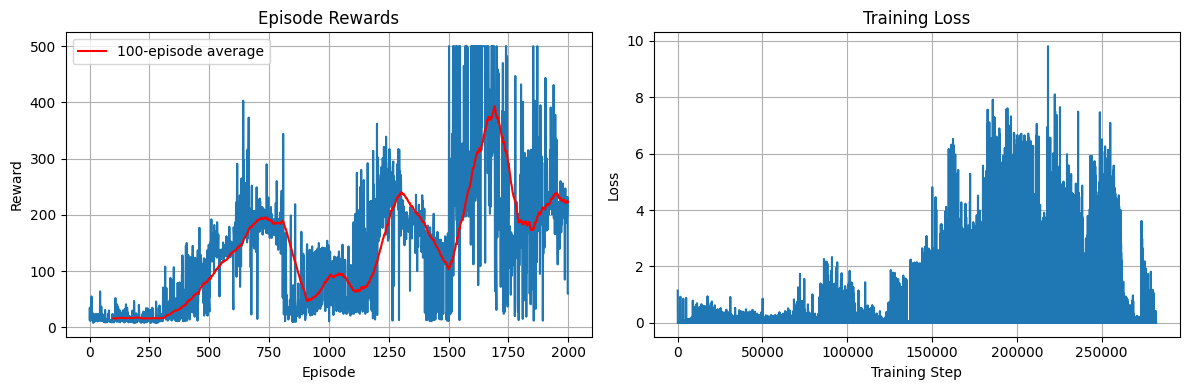

In [22]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Create and train agent
agent = DQNAgent(
    env=env,
    learning_rate=0.001,
    initial_epsilon=1.0,
    epsilon_decay=0.995,
    final_epsilon=0.01,
    discount_factor=0.99,
    buffer_capacity=10000,
    batch_size=64,
    target_update_frequency=100,
    hidden_size=128
)

# Train the agent
n_episodes = 2000
agent.train(n_episodes)

# Test the trained agent
test_rewards = test_agent(agent, env, num_episodes=100)

# Plot results
plot_training_progress(agent)

# Close environment
env.close()

### Demo del agente

In [23]:
def visualize_agent(agent, num_episodes=5):
    """Visualize the trained agent playing CartPole with graphical interface."""
    print(f"\nVisualizing agent for {num_episodes} episodes...")
    print("Close the window to stop visualization.")
    
    # Create environment with human rendering
    vis_env = gym.make('CartPole-v1', render_mode='human')
    
    # Disable exploration for visualization
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    try:
        for episode in range(num_episodes):
            state, _ = vis_env.reset()
            episode_reward = 0
            step_count = 0
            done = False
            
            print(f"\nEpisode {episode + 1}:")
            
            while not done:
                # Get action from trained agent
                action = agent.get_action(state)
                
                # Take action and render
                state, reward, terminated, truncated, _ = vis_env.step(action)
                done = terminated or truncated
                episode_reward += reward
                step_count += 1
                
                # Add small delay to make visualization watchable
                time.sleep(0.02)  # 50 FPS
            
            print(f"  Steps survived: {step_count}")
            print(f"  Total reward: {episode_reward}")
            
            # Pause between episodes
            if episode < num_episodes - 1:
                print("  Starting next episode in 2 seconds...")
                time.sleep(2)
    
    except KeyboardInterrupt:
        print("\nVisualization stopped by user.")
    
    finally:
        # Restore epsilon and close environment
        agent.epsilon = old_epsilon
        vis_env.close()

In [24]:
try:
    visualize_agent(agent, num_episodes=3)
except Exception as e:
    print(f"Visualization failed (this is normal in headless environments): {e}")
    print("To see visualization, run this on a system with display capabilities.")


Visualizing agent for 3 episodes...
Close the window to stop visualization.

Episode 1:
  Steps survived: 63
  Total reward: 63.0
  Starting next episode in 2 seconds...

Episode 2:
  Steps survived: 500
  Total reward: 500.0
  Starting next episode in 2 seconds...

Episode 3:
  Steps survived: 59
  Total reward: 59.0
